In [57]:

from scipy.optimize import minimize

import numpy as np
import torch
import os
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

from pointcloud.config_varients import caloclouds_3_simple_shower, caloclouds_3, default, caloclouds_2_v3


from pointcloud.utils.metadata import Metadata
from pointcloud.utils import detector_map
from pointcloud.data.read_write import read_raw_regaxes, get_n_events
from pointcloud.data.conditioning import read_raw_regaxes_withcond

# imports specific to this evaluation
from pointcloud.evaluation.bin_standard_metrics import (
    conditioned_sample_model,
    sample_accumulator,
    get_caloclouds_models,
)
from pointcloud.evaluation.calculate_scale_factors import construct_dsf, get_path, DetectorScaleFactors

redo = True
# Gather the models to evaluate
# the dict has the format {model_name: (model, shower_flow, config)}
# the config should hold correct hyperparameters for the model,
# but the dataset_path may be incorrect.
models = {}
log_base = "../point-cloud-diffusion-logs/"
# log_base = "/beegfs/desy/user/dayhallh/point-cloud-diffusion-logs/"
log_base = "/data/dust/user/dayhallh/point-cloud-diffusion-logs"
# data_base = "../point-cloud-diffusion-data/"
# data_base = "/beegfs/desy/user/dayhallh/point-cloud-diffusion-data/"
data_base = "/data/dust/user/dayhallh/point-cloud-diffusion-data/"
torch.set_default_dtype(torch.float32)

static_dataset = "/data/dust/user/dayhallh/data/ILCsoftEvents/highGran_g40_p22_th90_ph90_en10-100.hdf5"
static_n_files = 10
trim_edges[:] = 0


angular_dataset = caloclouds_3_simple_shower.Configs().dataset_path
angular_n_files = caloclouds_3_simple_shower.Configs().n_dataset_files

try:
    pass
    if True:  # new a1 model
        config = caloclouds_3_simple_shower.Configs()
        config.device = 'cpu'
        config.cond_features = 4
        config.diffusion_pointwise_hidden_l1 = 32
        config.distillation = True
        config.cond_features_names = ["energy", "p_norm_local"]
        config.trim_projected_edges = trim_edges
        caloclouds_paths = ["/data/dust/group/ilc/sft-ml/model_weights/CaloClouds/CC3/ckpt_0.000000_6135000.pt"]
        #showerflow_paths = ["/data/dust/group/ilc/sft-ml/model_weights/CaloClouds/CC3/ShowerFlow_alt1_nb2_inputs8070450532247928831_fnorms_dhist_best.pth"]
        showerflow_paths = ["/data/dust/group/ilc/sft-ml/model_weights/CaloClouds/CC3/ShowerFlow_alt1_nb2_inputs8070450532247928831_fnorms_best.pth"]


        caloclouds = get_caloclouds_models(
            caloclouds_paths=caloclouds_paths, showerflow_paths=showerflow_paths, caloclouds_names=["CaloClouds3"], showerflow_names=["ShowerFlow_a1_fnorms_2"],
            config=config
        )


        # generate some custom metadata that will allow comparison between this model and the old model
        train_dataset_meta = Metadata(caloclouds_3_simple_shower.Configs())
        meta_here = Metadata(caloclouds_2_v3.Configs())

        meta_here.incident_rescale = 127
        meta_here.n_pts_rescale = train_dataset_meta.n_pts_rescale
        meta_here.vis_eng_rescale = 3.5

       # try as in interance
        #meta_here.mean_cog[:] = [-4.06743696e-03, -2.27790998e-01,  1.10137465e+01]
        meta_here.mean_cog[:] = [-4.06743696e-03, 0.321829,  1.10137465e+01]
        meta_here.std_cog[:] = [1.24559791, 0.95357278, 2.59475371]

        meta_here.log_incident_mean = train_dataset_meta.log_incident_mean
        meta_here.log_incident_std = train_dataset_meta.log_incident_std
        meta_here.found_attrs += ["log_incident_mean", "log_incident_std"]

        # internally, showers are assumed to be scaled between 0 and 1
        # but in cc3, they are actually normalised to std=0.5 mean=0
        # so we can alter Zmax_global, Zmin_global, Xmax_global and Xmin_global
        # to get the scaling needed
        Xmean, Ymean, Zmean = -0.0074305227, -0.21205868, 12.359252
        Xstd, Ystd, Zstd = 22.4728036, 23.65837968, 5.305082

        #meta_here.Xmax_global = Ymean
        #meta_here.Xmin_global = 2*Ystd - Ymean
        #meta_here.Zmax_global = Xmean
        #meta_here.Zmin_global = 2*Xstd - Xmean
        meta_here.Xmax_global = 2*Ymean
        meta_here.Xmin_global = 2*(2*Ystd - Ymean)
        meta_here.Zmax_global = 2*Xmean
        meta_here.Zmin_global = 2*(2*Xstd - Xmean)

    
        print('\n~~~~~~~~\n')
        print(repr(meta_here))
        print('\n~~~~~~~~\n')

        caloclouds["CaloClouds3-ShowerFlow_a1_fnorms_2"][2].metadata = meta_here

        models.update(caloclouds)


    if True:
        config = caloclouds_2_v3.Configs()
        config.device = 'cpu'
        config.cond_features = 2  # number of conditioning features (i.e. energy+points=2)
        config.cond_features_names = ["energy", "points"]
        config.shower_flow_cond_features = ["energy"]
        config.n_dataset_files = static_n_files
        config.dataset_path_in_storage = False
        config.dataset_path = static_dataset
        config.shower_flow_roll_xyz = True
        config.trim_projected_edges = trim_edges
        config.distillation = True 
        #config.max_points = 6_000
        #config.max_points = 30_000
        #showerflow_paths = ["/data/dust/group/ilc/sft-ml/model_weights/CaloClouds/CC2/220714_cog_e_layer_ShowerFlow_best.pth"]
        #showerflow_paths = ["/data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/p22_th90_ph90_en10-100/ShowerFlow_original_nb10_inputs36893488147419103231_dhist_best.pth"]
        showerflow_paths = ["/data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/highGran_g40_p22_th90_ph90_en10-100/ShowerFlow_original_nb10_inputs36893488147419103231_dhist_try8_best.pth"]

        caloclouds_paths = ["/data/dust/group/ilc/sft-ml/model_weights/CaloClouds/CC2/ckpt_0.000000_1000000.pt"]

        caloclouds = get_caloclouds_models(
            caloclouds_paths=caloclouds_paths, showerflow_paths=showerflow_paths, caloclouds_names=["CaloClouds2"], showerflow_names=["ShowerFlow_CC2"],
            config=config
        )


        train_dataset_meta = Metadata(config)
        meta_here = Metadata(config)
        meta_here.mean_cog[:] = [-40.2, 0, 40]
        #meta_here.std_cog[:] = [1, 1, 0.5]
        meta_here.std_cog[:] = [0.53/0.38, 1., 0.52/0.85]
        print('\n~~~~~~~~\n')
        print("CC2")
        print(repr(meta_here))
        print(caloclouds["CaloClouds2-ShowerFlow_CC2"][2].max_points)
        print('\n~~~~~~~~\n')

        caloclouds["CaloClouds2-ShowerFlow_CC2"][2].metadata = meta_here

        models.update(caloclouds)
except FileNotFoundError as e:
    print("CaloClouds models not found")
    print(e)


config = caloclouds_3_simple_shower.Configs()
config.device = 'cpu'
config.dataset_path_in_storage = False
config._dataset_path = static_dataset
config.n_dataset_files = static_n_files
#config._dataset_path = angular_dataset
#config.n_dataset_files = angular_n_files
config.dataset_tag = "p22_th90_ph90_en10-100"
#config.dataset_tag = "sim-E1261AT600AP180-180"
model_name = "CaloClouds2-ShowerFlow_CC2"
save_name = get_path(config, model_name)
g4_gun = np.array([40, 50, 0])
#g4_gun = np.array([0, 30, 0])
n_events = 1_000
if os.path.exists(save_name) and False:
    dsf1 = DetectorScaleFactors.load(save_name)
    print("Loaded")
else:
    print("Constructing")
    model_gun = np.array([40, 50, 0])
    #model_gun = np.array([40, 30, 0])
    dsf1 = construct_dsf(config, model_name, models[model_name][2], models[model_name][0], models[model_name][1], model_gun_pos=model_gun, g4_gun_pos=g4_gun, max_g4_events=n_events)
    dsf1.save(save_name)

model_name_2 = 'CaloClouds3-ShowerFlow_a1_fnorms_2'
save_name_2 = get_path(config, model_name_2)
if os.path.exists(save_name_2) and False:
    dsf_2 = DetectorScaleFactors.load(save_name_2)
    print("Loaded")
else:
    print("Constructing")
    model_gun = np.array([40, 50, 0])
    #model_gun = np.array([0, 30, 0])
    dsf_2 = construct_dsf(config, model_name_2, models[model_name_2][2], models[model_name_2][0], models[model_name_2][1], model_gun_pos=model_gun, g4_gun_pos=g4_gun, max_g4_events=n_events)
    dsf_2.save(save_name_2)


/data/dust/group/ilc/sft-ml/model_weights/CaloClouds/CC3/ckpt_0.000000_6135000.pt
original_nb4_fnorms_wo[0, 1, 4] has best loss -145.9351401815609
alt1_nb4_fnorms_wo[0, 1, 4] has best loss -147.62754416952328
Found 10 saved models
/data/dust/group/ilc/sft-ml/model_weights/CaloClouds/CC3/ShowerFlow_alt1_nb2_inputs8070450532247928831_fnorms_best.pth

~~~~~~~~

Metadata for /data/dust/user/dayhallh/data/ILCsoftEvents/highGran_g40_p22_th90_ph90_en10-100_seed42_all_steps.hdf5
layer_bottom_pos_hdf5: [1811.34020996 1814.46508789 1823.81005859 1826.93505859 1836.2800293
 1839.4050293  1848.75       1851.875      1861.2199707  1864.3449707
 1873.68994141 1876.81494141 1886.16003418 1889.28503418 1898.63000488
 1901.75500488 1911.09997559 1914.22497559 1923.56994629 1926.69494629
 1938.14001465 1943.36499023 1954.81005859 1960.03503418 1971.47998047
 1976.70495605 1988.15002441 1993.375      2004.81994629 2010.04504395]
half_cell_size_global: 2.5441665649414062
cell_thickness_global: 0.525024414

100%|██████████| 1000/1000 [00:05<00:00, 181.55it/s]



Done
Constructing
Need to process Geant 4


100%|██████████| 1000/1000 [00:05<00:00, 182.06it/s]



Done


In [58]:


def plot_sample(dsf, model_name, n_samples, sample_n_coeff, sample_e_coeff=None, fake_n_coeff=None):
    mean_sq_n, mean_sq_e = dsf.divergance(n_samples, sample_n_coeff, sample_e_coeff, fake_n_coeff)
    cond_energies = dsf.cond["energy"][dsf.cond_idxs]
    g4_n = dsf.g4_detector_n[dsf.cond_idxs]
    g4_e = dsf.g4_detector_e[dsf.cond_idxs]
    
    from matplotlib import pyplot as plt
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    scatter_args = dict(alpha=0.5)
    axs[0].set_ylabel("Active cells")
    axs[1].set_ylabel("Detected energy")
    axs[0].scatter(cond_energies, g4_n, label="g4", **scatter_args)
    axs[0].scatter(cond_energies, dsf.model_n, label=model_name, **scatter_args)
    axs[1].scatter(cond_energies, g4_e, label="g4", **scatter_args)
    axs[1].scatter(cond_energies, dsf.model_e, label=model_name, **scatter_args)
    
    for ax in axs:
        ax.legend()
        ax.set_xlabel("Conditioning energy")
    axs[0].set_title(f"Mean squared error = {mean_sq_n}")
    axs[1].set_title(f"Mean squared error = {mean_sq_e}")

100%|██████████| 1000/1000 [00:08<00:00, 122.15it/s]


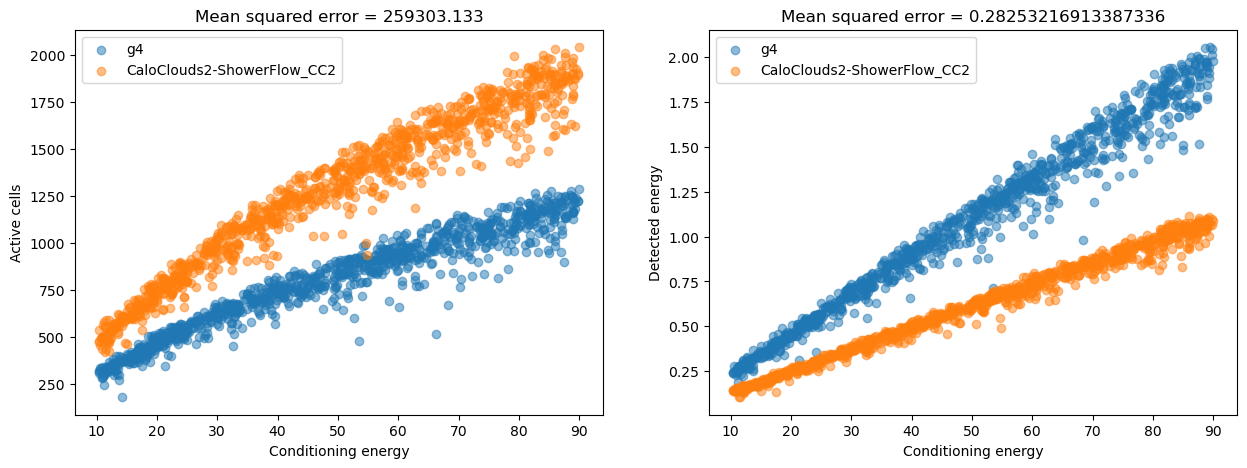

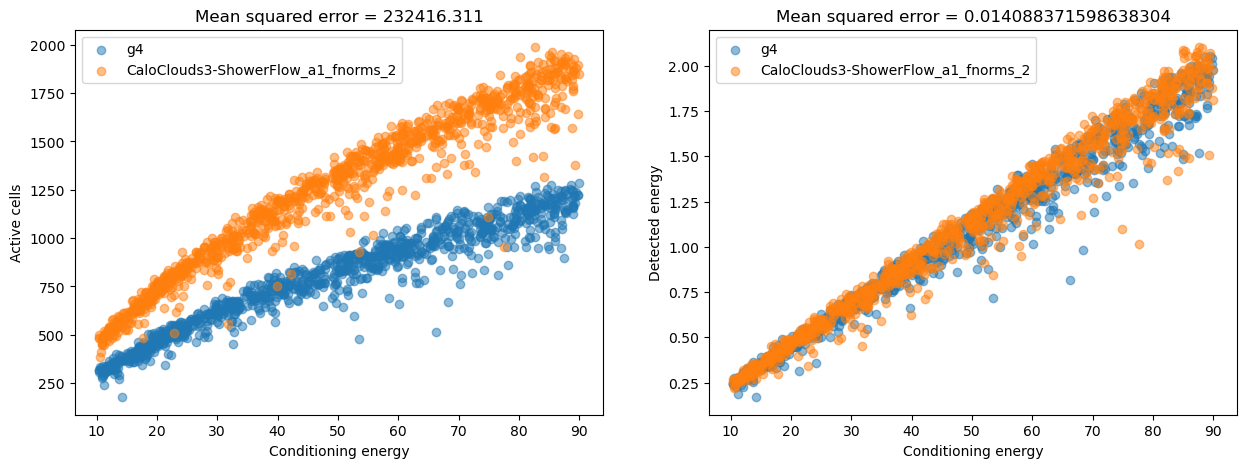

In [59]:

n_samples = dsf1.n_retained
sample_n_coeff = np.zeros(4)
sample_n_coeff[-2] = 1.
sample_e_coeff = np.array([5.486e-01, 0.])
sample_e_coeff_2 = np.array([9.768e-01, 0.])
plot_sample(dsf1, model_name, n_samples, sample_n_coeff, sample_e_coeff)
plot_sample(dsf_2, model_name_2, n_samples, sample_n_coeff, sample_e_coeff_2)

dict_keys(['g4_events', 'cond_energy', 'cond_points', 'cond_p_norm_local', 'g4_projected', 'g4_projected_postMip', 'raw_model_events', 'model_events', 'model_projected', 'model_projected_postMip'])


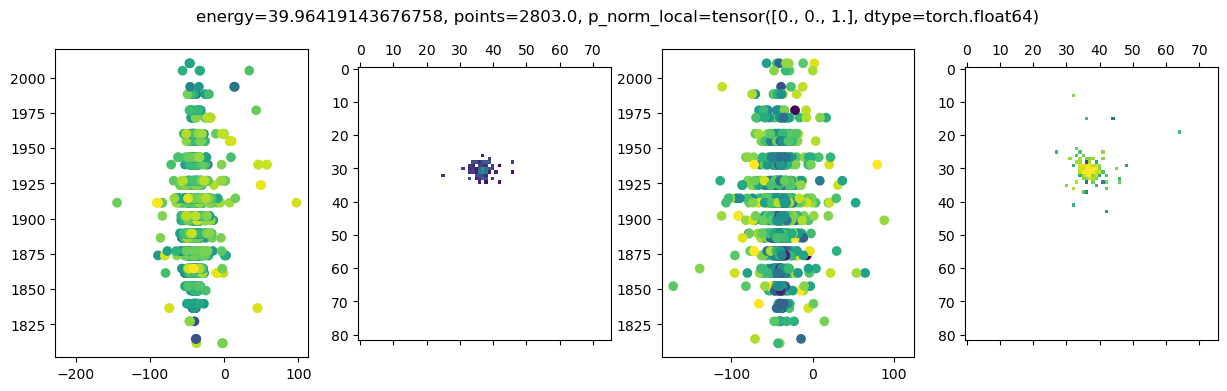

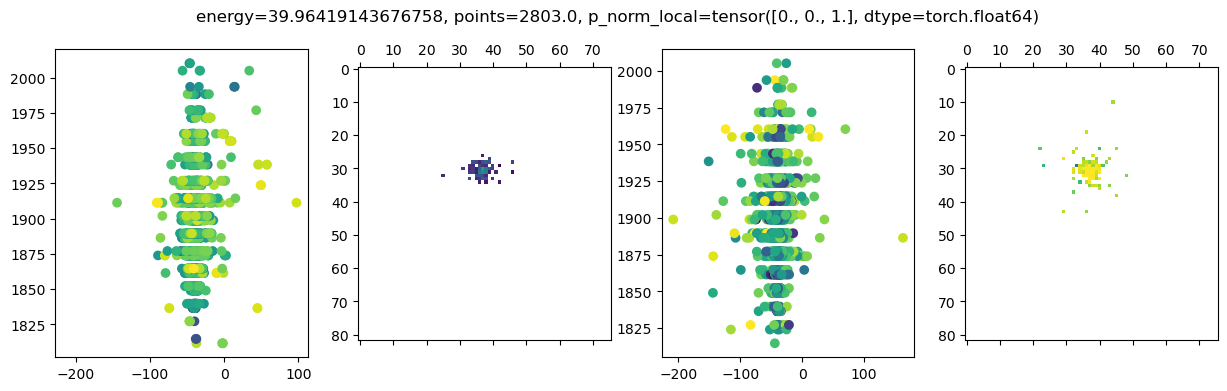

In [60]:


print(dsf1.retain_dict.keys())

for dsf in [dsf1, dsf_2]:
    i = 0
    l = 15
    x = 0
    y = 2
    c = 1
    fig, axarr = plt.subplots(1, 4, figsize=(15, 4))
    fig.suptitle(f"energy={dsf.retain_dict['cond_energy'][i][0]}, points={dsf.retain_dict['cond_points'][i][0]}, p_norm_local={dsf.retain_dict['cond_p_norm_local'][i][:]}")
    vmin, vmax = 0.0001, 1
    vmin2, vmax2 = 0.1, 100
    g4_evt = dsf.retain_dict['g4_events'][i]
    g4_evt = g4_evt[g4_evt[:, 3]>0]
    md_evt = dsf.retain_dict['raw_model_events'][i]
    md_evt = md_evt[md_evt[:, 3]>0]
    axarr[0].scatter(g4_evt[:, x], g4_evt[:, y], c=g4_evt[:, c], norm=LogNorm(vmin=vmin2, vmax=vmax2))
    axarr[1].matshow(dsf.retain_dict['g4_projected_postMip'][i][l], norm=LogNorm(vmin=vmin, vmax=vmax))
    axarr[2].scatter(md_evt[:, x], md_evt[:, y], c=md_evt[:, c], norm=LogNorm(vmin=vmin2, vmax=vmax2))
    axarr[3].matshow(dsf.retain_dict['model_projected_postMip'][i][l], norm=LogNorm(vmin=vmin, vmax=vmax))

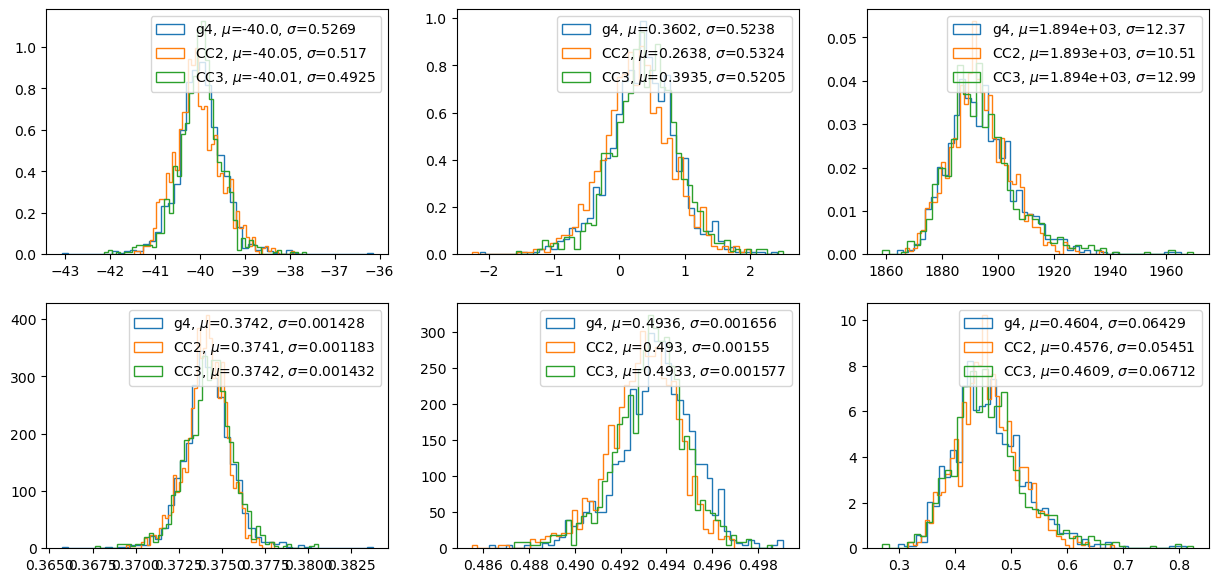

In [61]:
labels = ["g4", "CC2", "CC3"]
before = [dsf1.retain_dict['g4_events']] + [dsf.retain_dict['model_events'] for dsf in [dsf1, dsf_2]]
after =  [dsf1.retain_dict['g4_projected']] + [dsf.retain_dict['model_projected'] for dsf in [dsf1, dsf_2]]
before_cogs = []
after_cogs = []
after_x_pos = [np.linspace(0, 1, len(l))[:, None] for l in after[0][0]]
after_y_pos = [np.linspace(0, 1, len(l[0])) for l in after[0][0]]
after_z_pos = np.linspace(0, 1, len(after[0][0]))

for i in range(3):
    b = np.array(before[i])
    m = (b[:, :, 3]>0)[:, :, None]
    cogs = np.sum((m*b[:, :, :3]*b[:, :, [3]]), axis=1)/np.sum(m*b[:, :, [3]], axis=1)
    before_cogs.append(cogs)
    denominator = np.zeros_like(cogs)
    numerator = np.zeros(len(cogs))
    a = after[i]
    for e, event in enumerate(a):
        for l, layer in enumerate(event):
            denominator[e, 0] += np.sum(after_x_pos[l]*layer)
            denominator[e, 1] += np.sum(after_y_pos[l]*layer)
            denominator[e, 2] += np.sum(after_z_pos[l]*layer)
            numerator[e] += np.sum(layer)
    after_cogs.append(denominator/numerator[:, None])
        
fig, axarr = plt.subplots(2, 3, figsize=(15, 7))

for axline, cogs in [(axarr[0], before_cogs), (axarr[1], after_cogs)]:
    for label, cog in zip(labels, cogs):
        mean = np.mean(cog, axis=0)
        std = np.std(cog, axis=0)
        for i in range(3):
            l = f"{label}, $\mu$={mean[i]:.4}, $\sigma$={std[i]:.4}"
            axline[i].hist(cog[:, i], label=l, histtype='step', bins=50, density=True)

for ax in axarr.flatten():
    ax.legend()


100%|██████████| 500/500 [00:02<00:00, 177.75it/s]


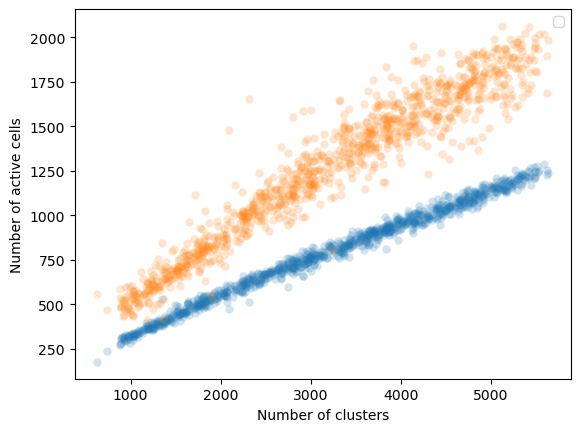

In [62]:

points = dsf1.cond['points']

unit = np.zeros(2)
unit[0] = 1.
batch_size = 500
total_events = len(dsf1.cond['energy'])
all_model_n, all_model_e = np.empty(total_events), np.empty(total_events)
for batch_start in range(0, total_events, batch_size):
    batch_end = min(batch_size+batch_start, total_events)
    batch_idxs = list(range(batch_start, batch_end))
    n, e = dsf1.model_events(batch_idxs, unit, None)
    all_model_n[batch_start:batch_end] = n
    all_model_e[batch_start:batch_end] = e

from matplotlib import pyplot as plt
plt.scatter(points, dsf1.g4_detector_n, alpha=0.2, lw=0)
plt.scatter(points, all_model_n, alpha=0.2, lw=0)
plt.legend()
plt.xlabel("Number of clusters")
plt.ylabel("Number of active cells")
xs = np.linspace(500, 5500)


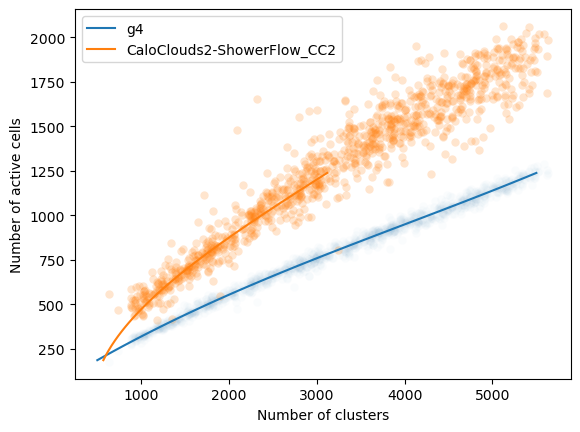

In [63]:

from matplotlib import pyplot as plt
xs = np.linspace(500, 5500)
plt.scatter(points, dsf1.g4_detector_n, alpha=0.02, lw=0)
plt.legend()
plt.xlabel("Number of clusters")
plt.ylabel("Number of active cells")
plt.scatter(points, all_model_n, alpha=0.2, lw=0)
if hasattr(dsf1, "real_coeff") and not redo:
    real_coeff = dsf1.real_coeff
    fake_coeff = dsf1.fake_coeff
    print("Previously calculated")
else:
   
    real_coeff = np.polyfit(points.flatten(), dsf1.g4_detector_n, 3)
    fake_coeff = np.polyfit(all_model_n, points.flatten(), 3)
    dsf1.real_coeff = real_coeff
    dsf1.fake_coeff = fake_coeff
    dsf1.save(save_name)
    
    
ys = np.polyval(real_coeff, xs)
plt.plot(xs, np.polyval(real_coeff, xs), label="g4")
plt.plot(np.polyval(fake_coeff, ys), ys, label=model_name)
plt.legend()

In [64]:
fake_coeff, real_coeff

(array([-6.11479520e-07,  2.35930868e-03,  1.63197403e-01,  4.60061658e+02]),
 array([ 2.45874828e-09, -2.96085516e-05,  3.06121175e-01,  4.08541640e+01]))

100%|██████████| 100/100 [00:00<00:00, 177.94it/s]


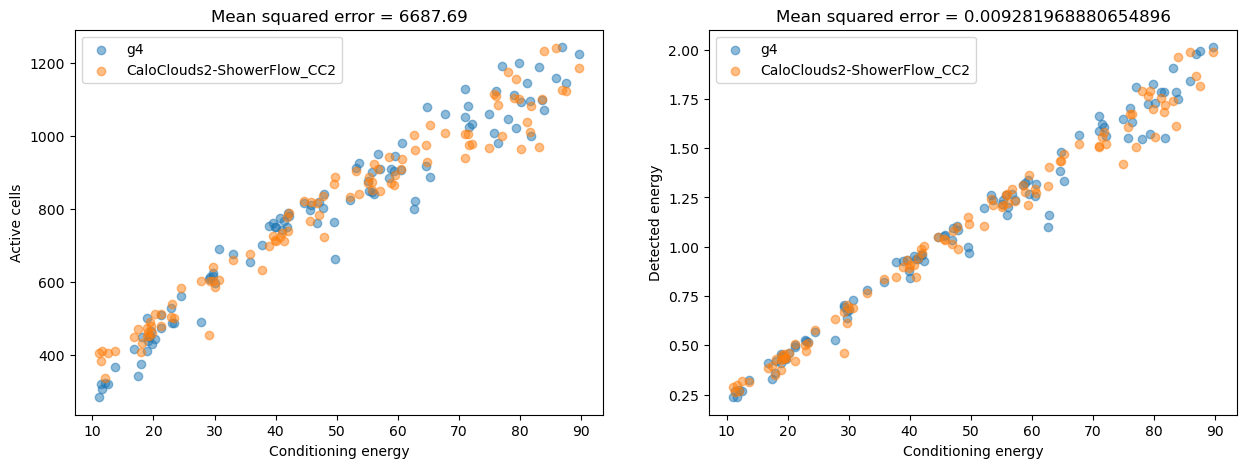

In [65]:
n_samples=100
plot_sample(dsf1, model_name, n_samples, real_coeff, None, fake_coeff)

100%|██████████| 500/500 [00:03<00:00, 128.61it/s]


Text(0, 0.5, 'Number of active cells')

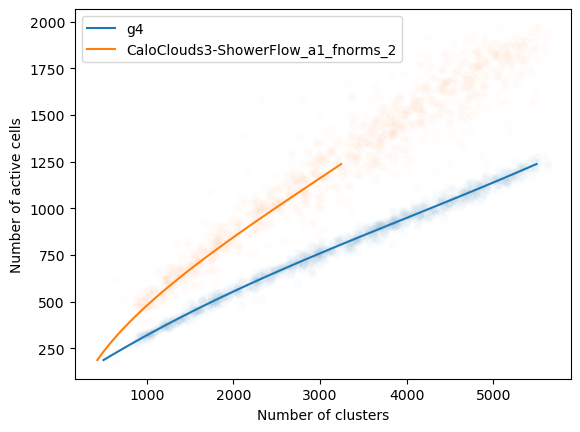

In [66]:

points_2 = dsf_2.cond['points']

if hasattr(dsf_2, "real_coeff") and not redo:
    real_coeff_2 = dsf_2.real_coeff
    fake_coeff_2 = dsf_2.fake_coeff
    print("Previously calculated")
else:
    unit = np.zeros(2)
    unit[0] = 1.
    batch_size = 500
    total_events_2 = len(dsf_2.cond['energy'])
    all_model_n_2, all_model_e_2 = np.empty(total_events_2), np.empty(total_events_2)
    for batch_start in range(0, total_events_2, batch_size):
        batch_end = min(batch_size+batch_start, total_events_2)
        batch_idxs = list(range(batch_start, batch_end))
        n, e = dsf_2.model_events(batch_idxs, unit, None)
        all_model_n_2[batch_start:batch_end] = n
        all_model_e_2[batch_start:batch_end] = e
    real_coeff_2 = np.polyfit(points_2.flatten(), dsf_2.g4_detector_n, 3)
    fake_coeff_2 = np.polyfit(all_model_n_2, points_2.flatten(), 3)
    dsf_2.real_coeff = real_coeff_2
    dsf_2.fake_coeff = fake_coeff_2
    dsf_2.save(save_name_2)

from matplotlib import pyplot as plt
plt.scatter(points_2, dsf_2.g4_detector_n, alpha=0.02, lw=0)
xs = np.linspace(500, 5500)
ys = np.polyval(real_coeff_2, xs)
plt.plot(xs, np.polyval(real_coeff_2, xs), label="g4")
plt.scatter(points_2, all_model_n_2, alpha=0.02, lw=0)
plt.plot(np.polyval(fake_coeff_2, ys), ys, label=model_name_2)
plt.legend()
plt.xlabel("Number of clusters")
plt.ylabel("Number of active cells")

In [ ]:

if hasattr(dsf1, "final_e_coeff") and not redo:
    sample_e_coeff_1 = dsf1.final_e_coeff
    print(f"Already done {sample_e_coeff_1}")
else:
    def to_minimise_1b(coeff_e):
        n_samples = 100
        sample_e_coeff = np.zeros(2, dtype=float)
        sample_e_coeff[0] = coeff_e
        mean_sq_n, mean_sq_e = dsf1.divergance(n_samples, real_coeff, sample_e_coeff, fake_coeff)
        return mean_sq_e
    res_e_coeff_1 = minimize(to_minimise_1b, x0=1., method='Powell', bounds=[(0.5, 1.5),], options={'disp': True, 'maxiter':1000, 'xtol':1e-6, 'ftol':1e-4})
    print(res_e_coeff_1)
    sample_e_coeff_1 = np.zeros(4)
    sample_e_coeff_1[-2] = res_e_coeff_1.x
    dsf1.final_e_coeff = sample_e_coeff_1
    dsf1.save(save_name)



 57%|█████▋    | 57/100 [00:00<00:00, 186.28it/s]

In [ ]:
n_samples=100
plot_sample(dsf1, model_name, n_samples, real_coeff, sample_e_coeff_1, fake_coeff)

In [ ]:

n_samples = 100
sample_n_coeff = np.zeros(4)
sample_n_coeff[-2] = 1.
plot_sample(dsf_2, model_name_2, n_samples, sample_n_coeff)

In [ ]:


def to_minimise_2a(coeff_n):
    n_samples = 500
    sample_n_coeff = np.zeros(2, dtype=float)
    sample_n_coeff[:] = coeff_n
    mean_sq_n, mean_sq_e = dsf_2.divergance(n_samples, sample_n_coeff)
    idxs = dsf_2.cond_idxs
    g4_n = dsf_2.g4_detector_n[idxs]
    model_n = dsf_2.model_n
    weighted_distance = np.sum(np.abs(g4_n-model_n)/(g4_n+model_n))
    return weighted_distance


    

if hasattr(dsf_2, "final_n_coeff") and not redo:
    sample_n_coeff = dsf_2.final_n_coeff
    print(f"Already done {sample_n_coeff}")
else:
    x0 = np.zeros(2)
    x0[0] = 1.
    res_n_coeff_2 = minimize(to_minimise_2a, x0=1., method='Powell', bounds=[(0.5, 1.5),], options={'disp': True, 'maxiter':1000, 'xtol':1e-6, 'ftol':1.})
    print(res_n_coeff_2)
    sample_n_coeff = np.zeros(2)
    sample_n_coeff[0] = res_n_coeff_2.x
    dsf_2.final_n_coeff = sample_n_coeff
    dsf_2.save(save_name_2)

In [ ]:
n_samples = 100

plot_sample(dsf_2, model_name_2, n_samples, sample_n_coeff)

In [ ]:


def to_minimise_2b(coeff_e):
    n_samples = 500
    sample_n_coeff = np.zeros(2, dtype=float)
    sample_n_coeff[0] = res_n_coeff_2.x
    sample_e_coeff = np.zeros(2, dtype=float)
    sample_e_coeff[0] = coeff_e
    mean_sq_n, mean_sq_e = dsf_2.divergance(n_samples, sample_n_coeff, sample_e_coeff)
    idxs = dsf_2.cond_idxs
    g4_e = dsf_2.g4_detector_e[idxs]
    model_e = dsf_2.model_e
    weighted_distance = np.sum((g4_e-model_e)**2/(g4_e+model_e)**2)
    return weighted_distance


if hasattr(dsf_2, "final_e_coeff") and not redo:
    sample_e_coeff = dsf_2.final_e_coeff
    print(f"Already done {sample_e_coeff}")
else:
    x0 = np.zeros(2, dtype=float)
    res_e_coeff_2 = minimize(to_minimise_2b, x0=1., method='Powell', bounds=[(0.5, 1.5),], options={'disp': True, 'maxiter':1000, 'xtol':1e-6, 'ftol':1e-4})
    print(res_e_coeff_2)
    sample_e_coeff = np.zeros(2)
    sample_e_coeff[0] = res_e_coeff_2.x
    dsf_2.final_e_coeff = sample_e_coeff
    dsf_2.save(save_name_2)



In [ ]:
n_samples = 100
plot_sample(dsf_2, model_name_2, n_samples, sample_n_coeff, sample_e_coeff)

In [ ]:
loaded = dict(np.load(save_name, allow_pickle=True))
loaded["real_coeff"] = real_coeff
loaded["fake_coeff"] = fake_coeff
loaded["final_e_coeff"] = sample_e_coeff_1
np.savez(save_name, **loaded)


In [ ]:
loaded = dict(np.load(save_name_2, allow_pickle=True))
loaded["final_n_coeff"] = sample_n_coeff
loaded["final_e_coeff"] = sample_e_coeff
np.savez(save_name_2, **loaded)

In [ ]:
real_coeff

In [ ]:
fake_coeff


In [ ]:
model_name_2


In [ ]:
sample_e_coeff_1

In [ ]:
sample_e_coeff

In [ ]:
sample_n_coeff

In [ ]:
save_name, save_name_2